In [ ]:
!pip install pandas matplotlib yfinance

In [40]:
# Import libraries yang dibutuhkan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import yfinance as yf
from math import sqrt
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score

In [3]:
# Define kode saham dan rentang waktu (1 tahun cukup)
stock_symbol = 'FTT-USD'
start_date = '2022-11-14'
end_date = '2023-11-14'

In [4]:
# Ambil bagian historical data
df = yf.download(stock_symbol, start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


In [5]:
# Pilih kolom 'Open' (butuhnya opening price)
ts = df['Open'].values

In [6]:
print(ts)

[1.49011004 1.47427404 1.83462596 1.62528396 1.56169605 1.45689595
 1.41655099 1.331622   1.25741601 1.33343196 1.29859698 1.37550104
 1.40119505 1.36450601 1.31575096 1.29403603 1.30423903 1.34015799
 1.29195297 1.30669999 1.31465304 1.38741302 1.39137304 1.45479798
 1.39118099 1.36426103 1.700912   1.51605797 1.52172601 1.48479998
 1.40507495 1.374439   1.35659301 1.14310801 1.07892501 1.04088998
 0.96074402 0.93813401 0.87397301 1.02713299 0.95750499 0.92443198
 0.89456701 0.93113798 0.92116201 0.88572299 0.86019301 0.83896798
 0.84297401 0.85811198 0.86230701 0.88518697 1.00226498 0.94411999
 0.91083902 0.90921497 0.91302401 1.32805502 1.24062502 1.30208302
 1.37791204 1.40603006 1.84186304 2.20495892 2.51167893 2.0784719
 1.76817    2.29456091 2.40961194 2.16448212 2.1053431  2.19820094
 1.83706999 1.96418798 1.88223898 1.98208296 1.91840398 2.05706811
 1.89022601 1.90903294 1.92808294 1.91345203 2.04355907 1.97289002
 1.90584099 1.92961597 2.03915596 1.95197594 1.58625102 1.62159

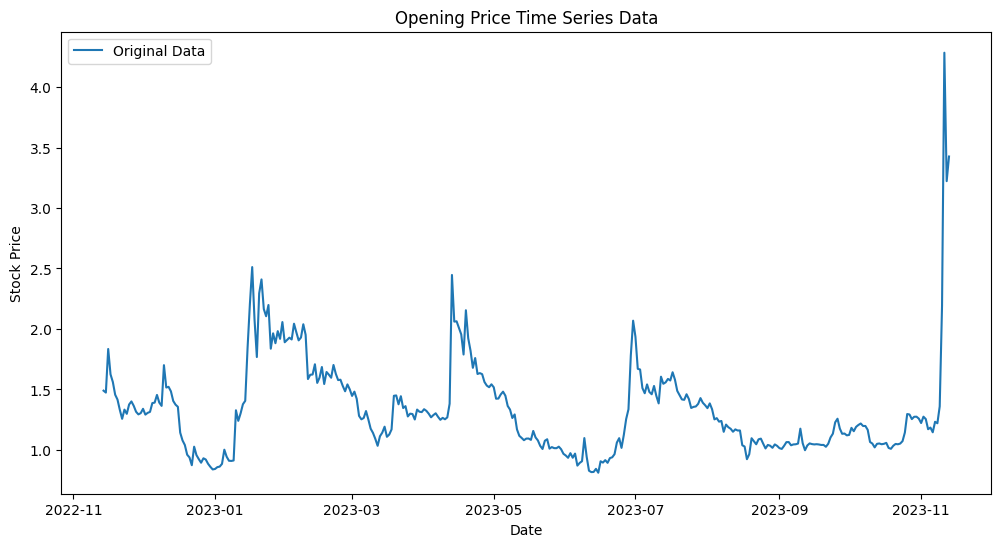

In [7]:
# Display time series plot dari original data opening price
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Open'], label='Original Data')
plt.title('Opening Price Time Series Data')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [8]:
# Normalisasi data
scaler = StandardScaler()
ts = scaler.fit_transform(np.array(ts).reshape(-1, 1))

In [9]:
# Prepare X_train dan X_test
seq_length = 30

X_train = []
y_train = []

for i in range(len(ts) - seq_length):
    X_train.append(ts[i:i + seq_length])
    y_train.append(ts[i + seq_length])

In [10]:
# Memastikan X_train dan y_train adalah numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)

In [11]:
# Split data menjadi training dan testing (80% training, 20% testing)
train_size = int(len(X_train) * 0.8)
X_train, X_test = X_train[:train_size], X_train[train_size:]
y_train, y_test = y_train[:train_size], y_train[train_size:]

In [12]:
# Model Architecture
model = keras.Sequential()
model.add(LSTM(128, activation='relu', return_sequences=True, input_shape=(seq_length, 1)))
model.add(Dropout(0.2))  # tambah dropout buat prevent overfitting
model.add(LSTM(128, activation='relu', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))

In [13]:
# Training Parameters
model.compile(optimizer='adam', loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)  # Early stopping callback

In [14]:
# Model Training
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/50
7/7 [==============================] - 16s 526ms/step - loss: 0.9158 - val_loss: 0.2750
Epoch 2/50
7/7 [==============================] - 1s 178ms/step - loss: 0.7125 - val_loss: 0.1058
Epoch 3/50
7/7 [==============================] - 1s 144ms/step - loss: 0.6825 - val_loss: 0.2441
Epoch 4/50
7/7 [==============================] - 1s 139ms/step - loss: 0.4640 - val_loss: 0.0268
Epoch 5/50
7/7 [==============================] - 1s 145ms/step - loss: 0.4033 - val_loss: 0.1017
Epoch 6/50
7/7 [==============================] - 1s 145ms/step - loss: 0.4063 - val_loss: 0.0284
Epoch 7/50
7/7 [==============================] - 1s 149ms/step - loss: 0.3793 - val_loss: 0.0333
Epoch 8/50
7/7 [==============================] - 2s 270ms/step - loss: 0.3182 - val_loss: 0.0429
Epoch 9/50
7/7 [==============================] - 2s 270ms/step - loss: 0.2826 - val_loss: 0.0235
Epoch 10/50
7/7 [==============================] - 2s 216ms/step - loss: 0.3205 - val_loss: 0.0503
Epoch 11/50
7/7 [=

In [15]:
# Model Evaluation
y_pred = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred)

3/3 [==============================] - 1s 55ms/step


In [16]:
# Menghitung RMSE dan MAE
rmse = sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

In [17]:
# Data Augmentation (di sini pakai Random Noise)
# tambah random noise ke training data
noise = np.random.normal(0, 0.1, X_train.shape)
X_train_noisy = X_train + noise
model.fit(X_train_noisy, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/50
7/7 [==============================] - 2s 257ms/step - loss: 0.2662 - val_loss: 0.0490
Epoch 2/50
7/7 [==============================] - 1s 150ms/step - loss: 0.2576 - val_loss: 0.0256
Epoch 3/50
7/7 [==============================] - 1s 149ms/step - loss: 0.2869 - val_loss: 0.0361
Epoch 4/50
7/7 [==============================] - 1s 151ms/step - loss: 0.3396 - val_loss: 0.0485
Epoch 5/50
7/7 [==============================] - 1s 148ms/step - loss: 0.2714 - val_loss: 0.0292
Epoch 6/50
7/7 [==============================] - 1s 148ms/step - loss: 0.2652 - val_loss: 0.0292
Epoch 7/50
7/7 [==============================] - 1s 144ms/step - loss: 0.2546 - val_loss: 0.0282
Epoch 8/50
7/7 [==============================] - 1s 165ms/step - loss: 0.2148 - val_loss: 0.0330
Epoch 9/50
7/7 [==============================] - 2s 239ms/step - loss: 0.2142 - val_loss: 0.0441
Epoch 10/50
7/7 [==============================] - 3s 457ms/step - loss: 0.2361 - val_loss: 0.0208
Epoch 11/50
7/7 [==

In [18]:
# Feature Engineering (di sini pake Adding Volume Data, untuk menambahkan informasi lebih ke analisis time series)
df['Volume'] = df['Volume'] / 1e7
additional_features = df['Volume'].values

In [19]:
# Concatenate additional features with X_train
additional_features = additional_features.reshape(-1, 1, 1)
additional_features = additional_features[-len(X_train):]
X_train = np.concatenate((X_train, additional_features), axis=1)


In [20]:
# Ensemble Methods
X_train_2d = X_train.reshape(X_train.shape[0], -1)
xgb_model = XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1)
xgb_model.fit(X_train_2d, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [21]:
from tensorflow.keras.regularizers import l2

# Regularization (L2 Regularization)
model = keras.Sequential()
model.add(LSTM(128, activation='relu', return_sequences=True, input_shape=(seq_length, 1), kernel_regularizer=l2(0.01)))
model.add(LSTM(128, activation='relu', return_sequences=True, kernel_regularizer=l2(0.01)))
model.add(LSTM(128, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(1))

In [22]:
# Menerapkan k-fold cross-validation (buat improve performance dari modelnya)
tscv = TimeSeriesSplit(n_splits=5)
rmses = []
maes = []

for train_index, test_index in tscv.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index, :seq_length], X_train[test_index, :seq_length]
    y_train_fold, y_val_fold = y_train[train_index], y_train[test_index]

    # Define dan train neural network model
    model = keras.Sequential()
    model.add(LSTM(128, activation='relu', return_sequences=True, input_shape=(seq_length, 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(128, activation='relu', return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mean_squared_error')
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    model.fit(X_train_fold, y_train_fold, validation_data=(X_val_fold, y_val_fold), epochs=50, batch_size=32, callbacks=[early_stopping])

    # Evaluasi model
    y_pred = model.predict(X_test)
    y_pred = scaler.inverse_transform(y_pred)

    rmse = sqrt(mean_squared_error(y_val_fold, model.predict(X_val_fold)))
    mae = mean_absolute_error(y_val_fold, model.predict(X_val_fold))

    rmses.append(rmse)
    maes.append(mae)

Epoch 1/50
2/2 [==============================] - 11s 678ms/step - loss: 1.8115 - val_loss: 0.6710
Epoch 2/50
2/2 [==============================] - 0s 201ms/step - loss: 1.7451 - val_loss: 0.4708
Epoch 3/50
2/2 [==============================] - 0s 179ms/step - loss: 1.6222 - val_loss: 0.2297
Epoch 4/50
2/2 [==============================] - 0s 188ms/step - loss: 1.4913 - val_loss: 6.4666
Epoch 5/50
2/2 [==============================] - 0s 242ms/step - loss: 1.3149 - val_loss: 3.3285
Epoch 6/50
2/2 [==============================] - 0s 248ms/step - loss: 1.0812 - val_loss: 0.5033
Epoch 7/50
2/2 [==============================] - 0s 173ms/step - loss: 0.8804 - val_loss: 0.1355
Epoch 8/50
2/2 [==============================] - 0s 197ms/step - loss: 0.7435 - val_loss: 0.2421
Epoch 9/50
2/2 [==============================] - 0s 167ms/step - loss: 0.6738 - val_loss: 0.3121
Epoch 10/50
2/2 [==============================] - 0s 169ms/step - loss: 0.7945 - val_loss: 0.4625
Epoch 11/50
2/2 [=

In [23]:
# Menghitung average RMSE dari cross-validation
mean_rmse = np.mean(rmses)
mean_mae = np.mean(maes)
print(f"Average RMSE: {mean_rmse}")
print(f"Average MAE: {mean_mae}")

Average RMSE: 0.35330607875068953
Average MAE: 0.26106443115292455


In [24]:
# Predictions untuk test data (X_test)
y_pred_test = model.predict(X_test)
y_pred_test = scaler.inverse_transform(y_pred_test)

3/3 [==============================] - 0s 27ms/step


In [25]:
print(y_pred_test)

[[1.1303103]
 [1.140067 ]
 [1.1487676]
 [1.1706034]
 [1.190493 ]
 [1.1987206]
 [1.1984546]
 [1.1944586]
 [1.1872735]
 [1.1791737]
 [1.1703944]
 [1.1633837]
 [1.1586946]
 [1.1542914]
 [1.1488894]
 [1.1459461]
 [1.1510426]
 [1.1664104]
 [1.2010695]
 [1.2548977]
 [1.3064305]
 [1.3415929]
 [1.3589635]
 [1.3591379]
 [1.3470578]
 [1.3348931]
 [1.3229141]
 [1.3158083]
 [1.3148175]
 [1.3193792]
 [1.3247496]
 [1.3284764]
 [1.3261423]
 [1.3100622]
 [1.2792786]
 [1.2377387]
 [1.1946201]
 [1.1556565]
 [1.1230937]
 [1.0983809]
 [1.0815611]
 [1.0687721]
 [1.0577068]
 [1.0501158]
 [1.0473373]
 [1.048981 ]
 [1.0548434]
 [1.0658764]
 [1.0891476]
 [1.1410164]
 [1.2141666]
 [1.2931155]
 [1.3652252]
 [1.4223795]
 [1.4605684]
 [1.4762866]
 [1.4779625]
 [1.4707808]
 [1.4494278]
 [1.4182825]
 [1.3770382]
 [1.3419355]
 [1.3155026]
 [1.3125423]
 [1.388205 ]
 [1.5665312]
 [1.7376797]]


In [26]:
# RMSE dan MAE dari test data
rmse_test = sqrt(mean_squared_error(y_test, y_pred_test))
mae_test = mean_absolute_error(y_test, y_pred_test)

print(f"RMSE for Test Data: {rmse_test}")
print(f"MAE for Test Data: {mae_test}")

RMSE for Test Data: 1.9627091715657017
MAE for Test Data: 1.8561397239073398


In [27]:
# forecasting
forecast_days = 5
X_forecast = np.copy(X_test[-1])

forecasted_values = []

for _ in range(forecast_days):
    forecasted_value = model.predict(X_forecast.reshape(1, seq_length, 1))
    forecasted_values.append(forecasted_value[0, 0])

    X_forecast = np.roll(X_forecast, -1)
    X_forecast[-1] = forecasted_value

forecasted_values = scaler.inverse_transform(np.array(forecasted_values).reshape(-1, 1))

1/1 [==============================] - 0s 38ms/step


In [28]:
print(forecasted_values)

[[1.7376797]
 [1.8803629]
 [1.9767157]
 [2.0291922]
 [2.0502706]]


In [29]:
# date range buat forecast
last_date = df.index[-1]
forecast_dates = pd.date_range(last_date, periods=forecast_days + 1)[1:]

# date range buat test data
test_dates = df.index[-len(y_pred_test):]

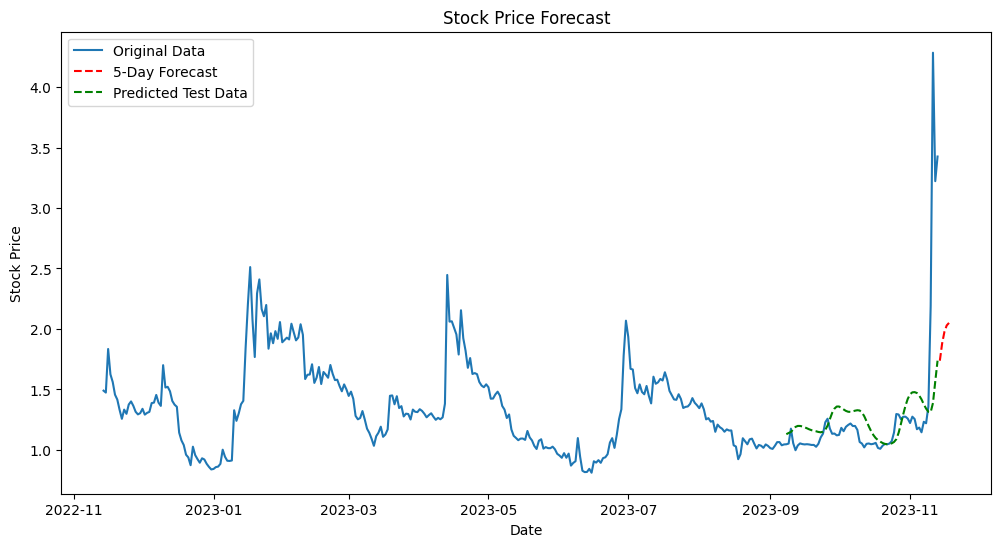

In [30]:
# Plot dari original data, predicted test data, dan forecasted values
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Open'], label='Original Data')
plt.plot(forecast_dates, forecasted_values, label='5-Day Forecast', linestyle='--', color='red')
plt.plot(test_dates, y_pred_test, label='Predicted Test Data', linestyle='--', color='green') # Adding the predicted test data
plt.title('Stock Price Forecast')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

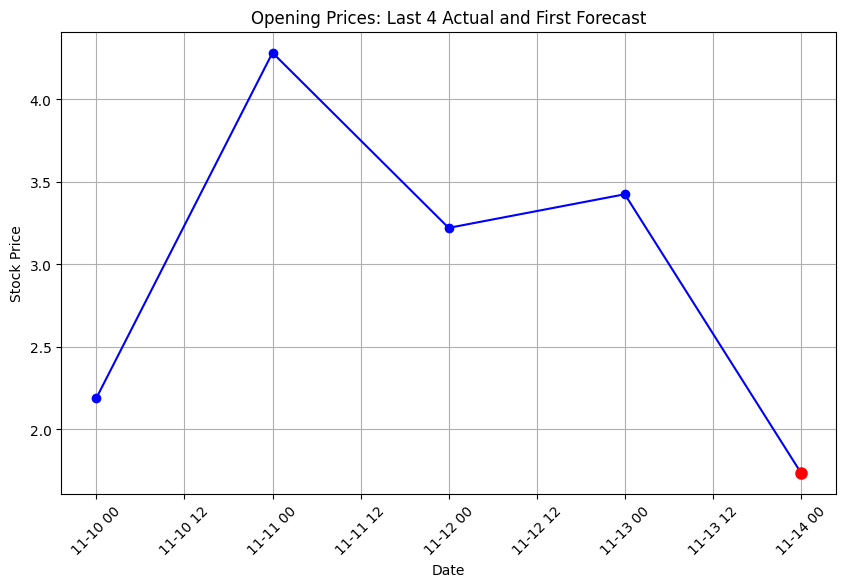

In [38]:
# Extract the last 4 actual opening prices and the first forecast opening price
last_4_actual_opening_prices = df['Open'][-4:]  # Last 4 actual opening prices
first_forecast_opening_price = forecasted_values[0][0]  # First forecast opening price

# Concatenate the last 4 actual opening prices and the first forecast opening price
plot_data = pd.concat([last_4_actual_opening_prices, pd.Series([first_forecast_opening_price], index=[forecast_dates[0]])])

# Plot the time series data
plt.figure(figsize=(10, 6))
plt.plot(plot_data.index, plot_data.values, marker='o', linestyle='-', color='blue')  # Blue line and dots

# Highlight the last point in red
plt.plot(plot_data.index[-1], plot_data.values[-1], marker='o', markersize=8, linestyle='--', color='red')  # Red dot for the last point

plt.title('Opening Prices: Last 4 Actual and First Forecast')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


In [50]:
# Calculate the difference in the opening stock price between the last day of the actual data and the first day of the forecast
last_actual_day = df.index[-1]  # Last day of the actual data
first_forecast_day = forecast_dates[0] # First day of the forecast

last_actual_opening_price = df['Open'][-1]  # Opening price of the last day in the actual data
first_forecast_opening_price = forecasted_values[0][0]  # Opening price of the first day in the forecast

price_difference = first_forecast_opening_price - last_actual_opening_price
percentage_change = price_difference/last_actual_opening_price*100

print(f"last actual opening price: {last_actual_day} = {last_actual_opening_price}")
print(f"first forecast opening price: {first_forecast_day} = {first_forecast_opening_price}")
print(f"Difference in opening stock price between last actual day and first forecast day: {price_difference}")
print(f"Change: {percentage_change}%")

last actual opening price: 2023-11-13 00:00:00 = 3.4254369735717773
first forecast opening price: 2023-11-14 00:00:00 = 1.7376797199249268
Difference in opening stock price between last actual day and first forecast day: -1.6877572536468506
Change: -49.271297842242575%


In [49]:
# adjusted percentage_change to be weighted metric
weighted_metric = (percentage_change + 100) / 2

print(f"weighted metric: {weighted_metric}%")

weighted metric: 25.364351078878713%


In [44]:
# Calculate R-squared score
r_squared = r2_score(y_test, y_pred_test)
print(f"R-squared Score: {r_squared}")

R-squared Score: -0.9738335392950506
